In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.io import loadmat

from aux import loadmat_h5, get_seg, get_outliers, mv_avg, align_t, zscore
from disp import set_plot, plot_b
from time_stats import nan_detrend

cc = np.concatenate

T_MAX = 420
T_NRL = np.arange(T_MAX)
NROI = 20

T_SINE = np.array([40, 70, 100])
T_PULSE = np.array([130, 160, 190])
T_NAT = np.array([220, 300, 380, 460])

FLY_IDX = 0

FLIES = ['221014_a1']
EXPTS = [
    [f'{FLIES[0]}_{ctr}' for ctr in range(2,3)],
]

BHV_IDX_FRAME = 1
BHV_IDX_TIME = 21
BHV_IDX_SPEED = 18
DT_BHV = 1

# FNAME_STIM = 'data/original/lin_imaging/nat_song_imaging/10min_blocksplus_stim_1_forplotting.mat'
# SAVE_DIR = f'data/view/lin_20220830'

In [2]:
# load behav
expts = EXPTS[FLY_IDX]
ntr = len(expts)

tbhvs = []
spds = []

for expt in expts:

    fname_bhv = f'data/original/lin_imaging/nat_song_imaging/{expt}/output.txt'

    df_bhv = pd.read_csv(fname_bhv, header=None)

    # df_bhv
    tbhv = np.array(df_bhv)[:, BHV_IDX_TIME] - np.array(df_bhv)[0, BHV_IDX_TIME]
    # converts to time in seconds
    spd = np.array(df_bhv)[:, BHV_IDX_SPEED].astype(float)
    
    tbhvs.append(tbhv)
    spds.append(spd)
    
# clean up time vectors and signal alignment
tbase, spds = align_t(tbhvs, spds, dt=DT_BHV)

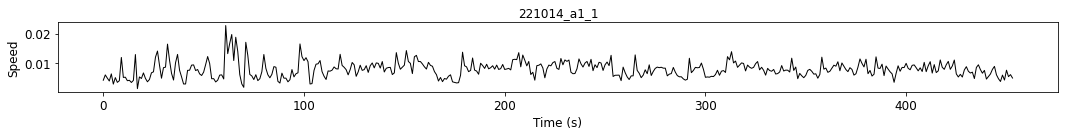

In [3]:
# plot behav
fig, ax = plt.subplots(1, 1, figsize=(15, 2*ntr), tight_layout=True, sharex=True)

for ctr, (spd, ax) in enumerate(zip(spds, [ax])):

    # plot stim and behav
    ax.plot(tbase, spd, c='k', lw=1)
    # plot_b(ax, tstim, stim, extent=[0, tstim.max(), -.01, -.005], c=[(.8, .8, .8), 'b', 'r'])
    set_plot(ax, x_label='Time (s)', y_label='Speed', title=f'{FLIES[FLY_IDX]}_{ctr+1}', font_size=12)

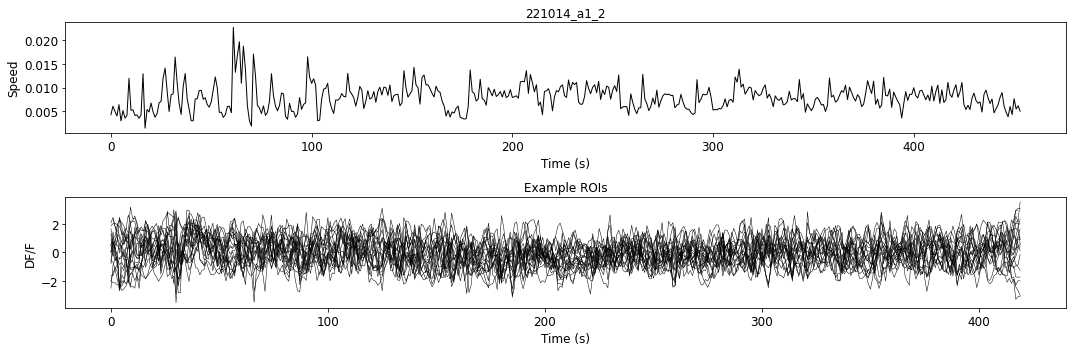

In [4]:
# load all neural data
dffs_all = []

expt = EXPTS[FLY_IDX][0]

data_dir = f'data/original/lin_imaging/nat_song_imaging/{expt}/supervoxels/'

dffs = []
slice_rois = []
for cslice in range(0, 9):
    fname = f'{expt}_n20_t420_slice{cslice}.h5'
    z_dff = loadmat_h5(os.path.join(data_dir, fname))['z_dff']

    for croi, dff in enumerate(z_dff.T):

        dff[get_outliers(dff, 3)] = np.nan
        dff = align_t([T_NRL], [dff], dt=DT_BHV, tbase=tbase)[1][0]
        dff = mv_avg(tbase, dff, 3)

        # z-score
        dff -= np.nanmean(dff)
        dff /= np.nanstd(dff)

        dffs.append(dff)
        
        slice_rois.append((cslice, croi+1))

dffs = np.array(dffs)
dffs_all.append(dffs)

fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True)
axs[0].plot(tbase, spds[ctr], c='k', lw=1)
set_plot(axs[0], x_label='Time (s)', y_label='Speed', title=f'{FLIES[FLY_IDX]}_2', font_size=12)

axs[1].plot(tbase, (dffs).T[:, :20], c='k', lw=.5)
set_plot(axs[1], x_label='Time (s)', y_label='DF/F', title='Example ROIs', font_size=12)

# Plot individual ROIs

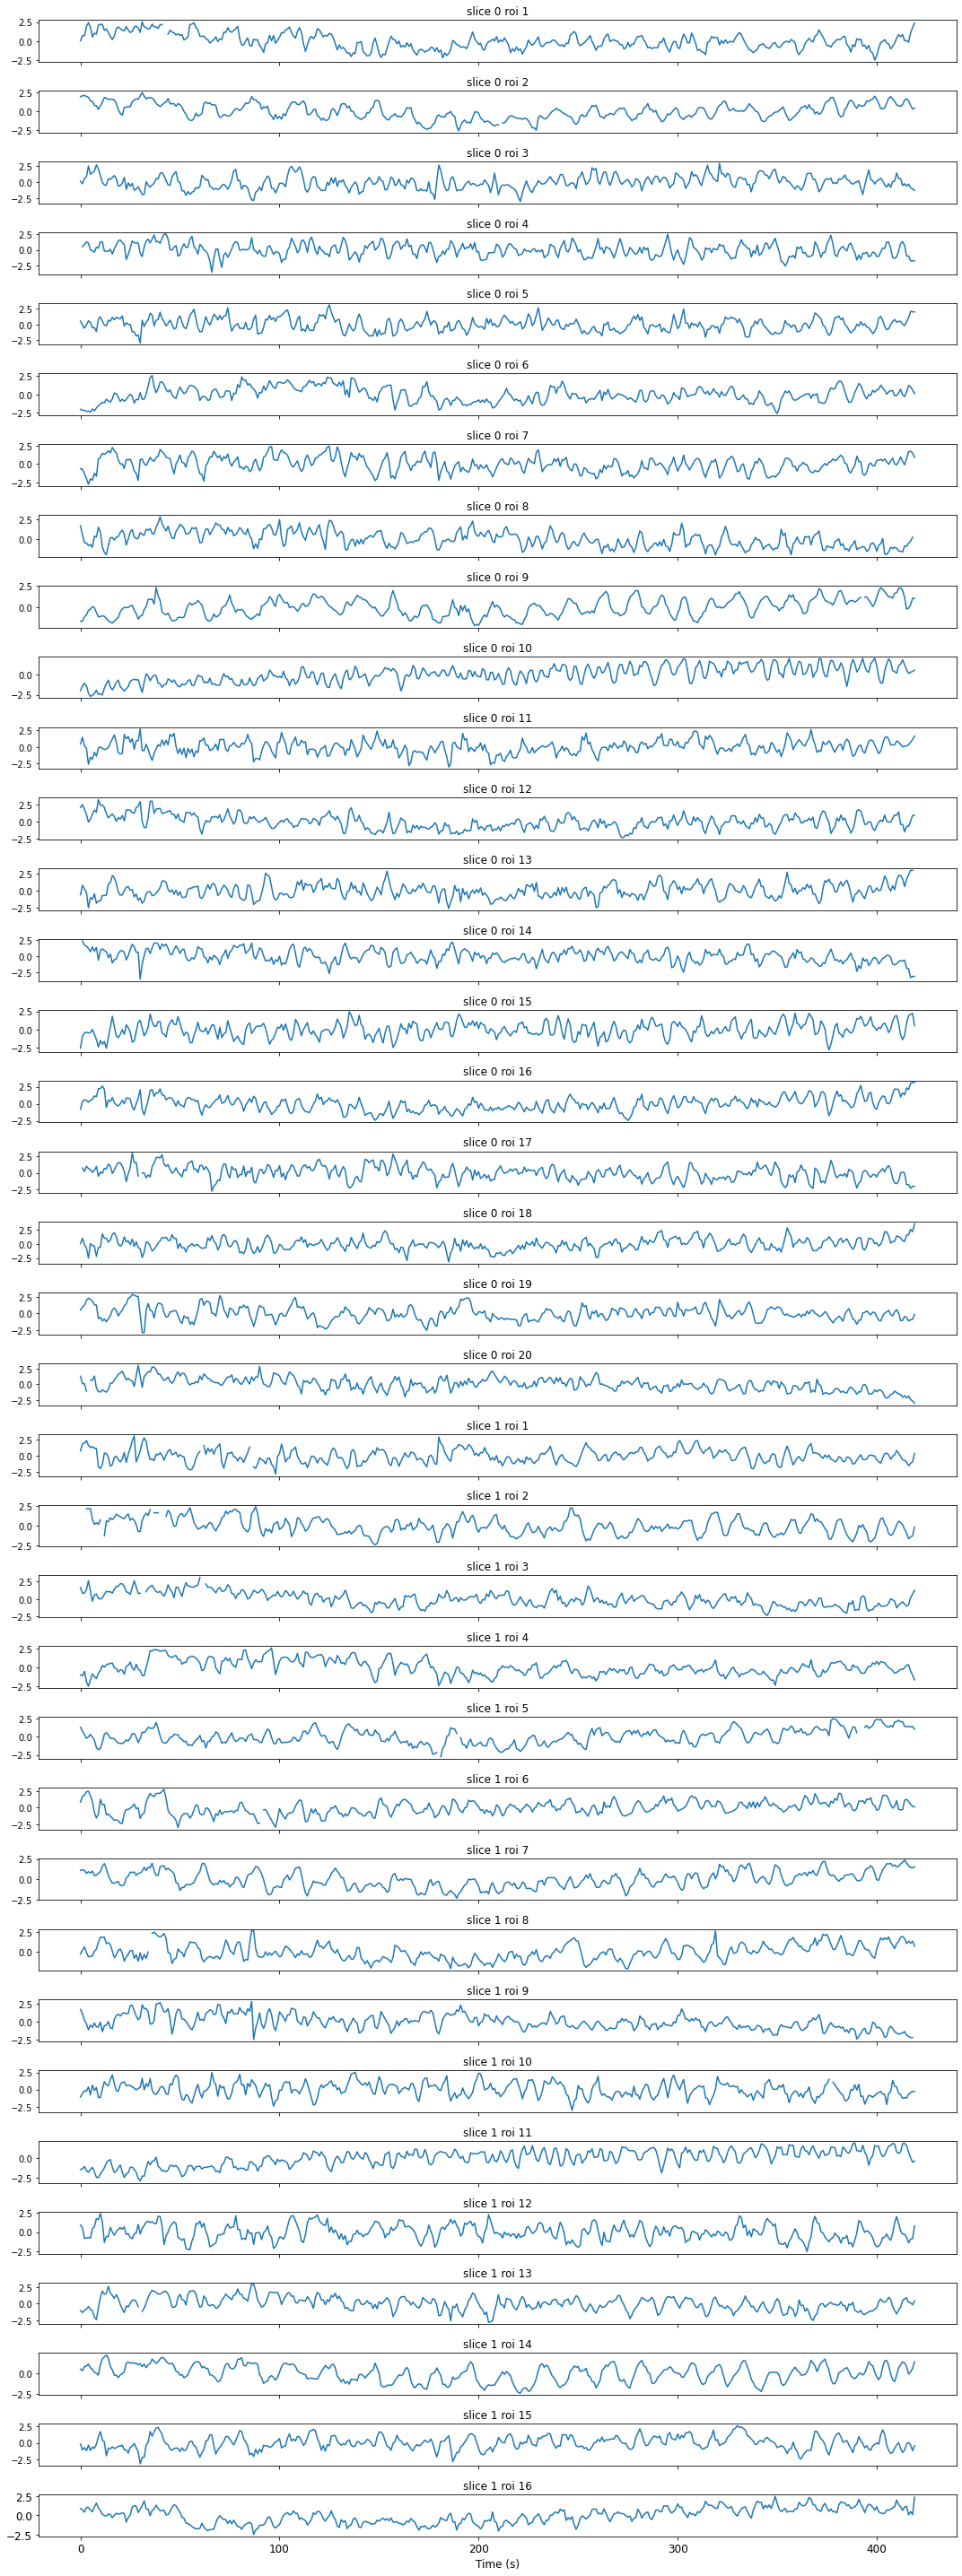

In [5]:
fig, axs = plt.subplots(36, 1, figsize=(15, 40), tight_layout=True, sharex=True)
n_per_ax = 1
for cax, ax in enumerate(axs):
    istart = cax*n_per_ax
    istop = (cax+1)*n_per_ax
    ax.plot(tbase, dffs.T[:, istart:istop])
    title = ', '.join([f'slice {cslice} roi {roi}' for cslice, roi in slice_rois[istart:istop]])
    set_plot(ax, title=title)
    
set_plot(axs[-1], x_label='Time (s)', font_size=12)

# Plot all ROIs

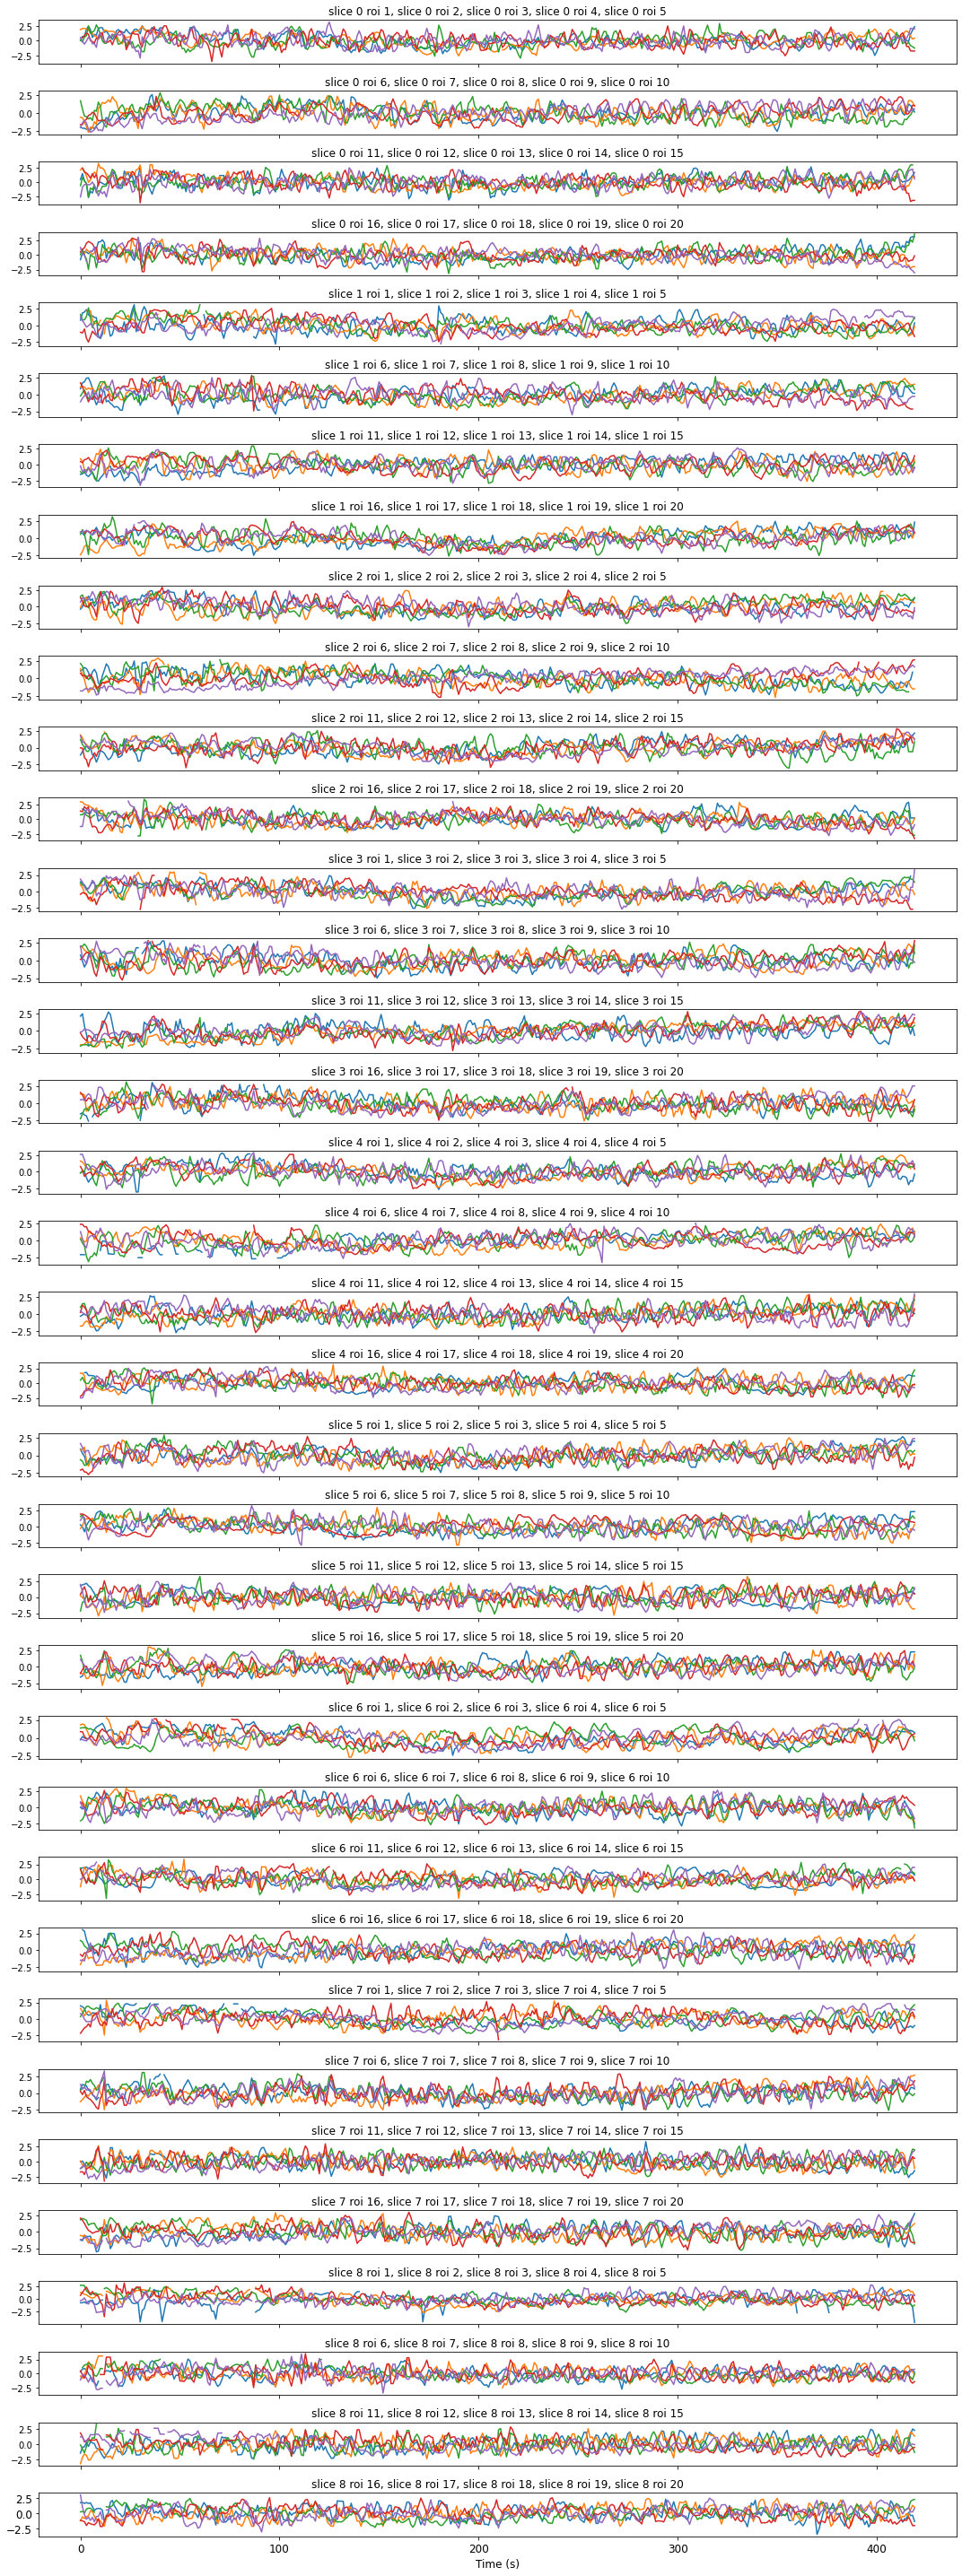

In [6]:
fig, axs = plt.subplots(36, 1, figsize=(15, 40), tight_layout=True, sharex=True)
n_per_ax = 5
for cax, ax in enumerate(axs):
    istart = cax*n_per_ax
    istop = (cax+1)*n_per_ax
    ax.plot(tbase, dffs.T[:, istart:istop])
    title = ', '.join([f'slice {cslice} roi {roi}' for cslice, roi in slice_rois[istart:istop]])
    set_plot(ax, title=title)
    
set_plot(axs[-1], x_label='Time (s)', font_size=12)

In [23]:
# look at distance traveled vs time for detrended responses
r_dtrs = np.array([nan_detrend(dff) for dff in dffs])


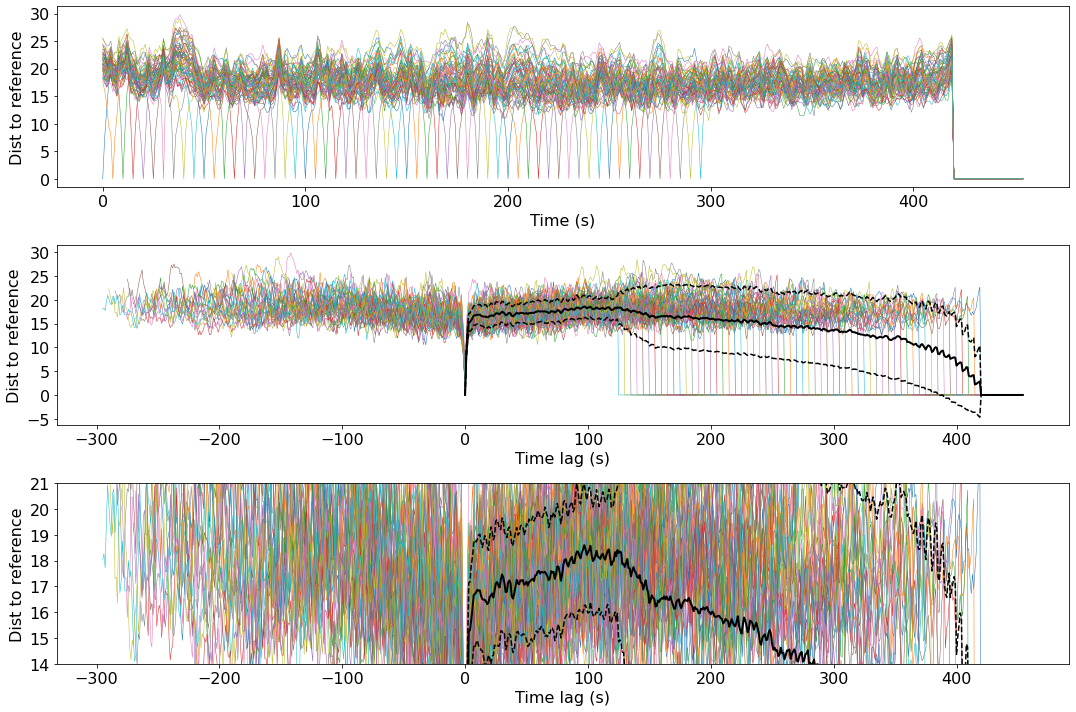

In [32]:
T_REFS = np.arange(0, 300, 5)
nt = dffs.shape[1]

fig, axs = plt.subplots(3, 1, figsize=(15, 10), tight_layout=True)

# rs = r_norms
rs = r_dtrs

ds_fwd = np.nan*np.zeros((len(T_REFS), nt))
t_fwd = np.arange(ds_fwd.shape[1])


for ct_ref, t_ref in enumerate(T_REFS):
    it_ref = int(round(t_ref/1))
    r_ref = rs[:, it_ref]
    d = np.sqrt(np.nansum((rs.T - r_ref)**2, 1))
    
    axs[0].plot(tbase, d, lw=.5)
    axs[1].plot(tbase-t_ref, d, lw=.5)
    axs[2].plot(tbase-t_ref, d, lw=.5)
    
    set_plot(axs[0], x_label='Time (s)', y_label='Dist to reference', font_size=16)
    set_plot(axs[1], x_label='Time lag (s)', y_label='Dist to reference', font_size=16)
    set_plot(axs[2], x_label='Time lag (s)', y_label='Dist to reference', font_size=16)
    
    ds_fwd[ct_ref, :(nt-it_ref)] = d[it_ref:].copy()
    
axs[1].plot(t_fwd, np.nanmean(ds_fwd, axis=0), c='k', lw=2)
axs[1].plot(t_fwd, np.nanmean(ds_fwd, axis=0) - np.nanstd(ds_fwd, axis=0), c='k', ls='--')
axs[1].plot(t_fwd, np.nanmean(ds_fwd, axis=0) + np.nanstd(ds_fwd, axis=0), c='k', ls='--')
axs[2].plot(t_fwd, np.nanmean(ds_fwd, axis=0), c='k', lw=2)
axs[2].plot(t_fwd, np.nanmean(ds_fwd, axis=0) - np.nanstd(ds_fwd, axis=0), c='k', ls='--')
axs[2].plot(t_fwd, np.nanmean(ds_fwd, axis=0) + np.nanstd(ds_fwd, axis=0), c='k', ls='--')
set_plot(axs[2], y_lim=(14, 21))

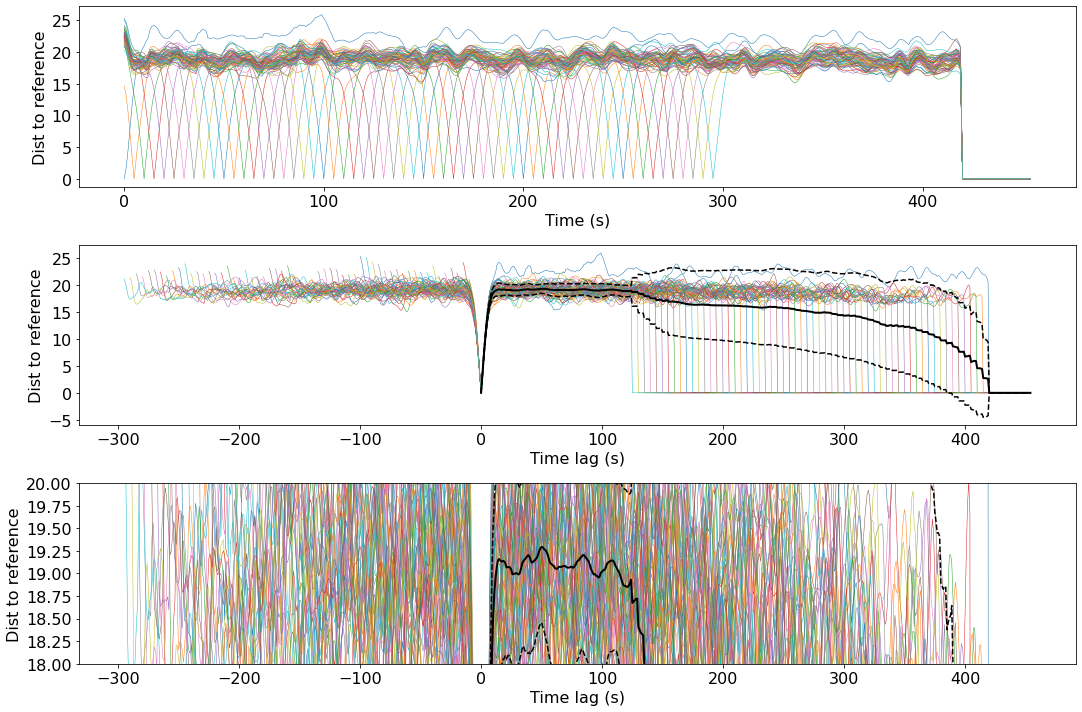

In [29]:
# EQUIVALENT ANALYSIS ON SMOOTHED WHITE NOISE
T_REFS = np.arange(0, 300, 5)
nt = rs.shape[1]

from scipy.ndimage import gaussian_filter1d

r_norms = []
for r_dtr in r_dtrs:
    r_norm = gaussian_filter1d(np.random.randn(r_dtrs.shape[1]), 3)
    r_norm[np.isnan(r_dtr)] = np.nan
    r_norm -= np.nanmean(r_norm)
    r_norm /= np.nanstd(r_norm)
    r_norm = nan_detrend(r_norm)
    r_norms.append(r_norm.copy())
r_norms = np.array(r_norms)
fig, axs = plt.subplots(3, 1, figsize=(15, 10), tight_layout=True)

rs = r_norms
# rs = r_dtrs

ds_fwd = np.nan*np.zeros((len(T_REFS), nt))
t_fwd = np.arange(ds_fwd.shape[1])


for ct_ref, t_ref in enumerate(T_REFS):
    it_ref = int(round(t_ref/1))
    r_ref = rs[:, it_ref]
    d = np.sqrt(np.nansum((rs.T - r_ref)**2, 1))
    
    axs[0].plot(tbase, d, lw=.5)
    axs[1].plot(tbase-t_ref, d, lw=.5)
    axs[2].plot(tbase-t_ref, d, lw=.5)
    
    set_plot(axs[0], x_label='Time (s)', y_label='Dist to reference', font_size=16)
    set_plot(axs[1], x_label='Time lag (s)', y_label='Dist to reference', font_size=16)
    set_plot(axs[2], x_label='Time lag (s)', y_label='Dist to reference', font_size=16)
    
    ds_fwd[ct_ref, :(nt-it_ref)] = d[it_ref:].copy()
    
axs[1].plot(t_fwd, np.nanmean(ds_fwd, axis=0), c='k', lw=2)
axs[1].plot(t_fwd, np.nanmean(ds_fwd, axis=0) - np.nanstd(ds_fwd, axis=0), c='k', ls='--')
axs[1].plot(t_fwd, np.nanmean(ds_fwd, axis=0) + np.nanstd(ds_fwd, axis=0), c='k', ls='--')
axs[2].plot(t_fwd, np.nanmean(ds_fwd, axis=0), c='k', lw=2)
axs[2].plot(t_fwd, np.nanmean(ds_fwd, axis=0) - np.nanstd(ds_fwd, axis=0), c='k', ls='--')
axs[2].plot(t_fwd, np.nanmean(ds_fwd, axis=0) + np.nanstd(ds_fwd, axis=0), c='k', ls='--')
set_plot(axs[2], y_lim=(18, 20))